In [8]:
import meep as mp
import numpy as np
import matplotlib.pyplot as plt
import json
import os

keyword = "Normal"
path = "SurfaceData/surfaceParams" + keyword + ".json"
def load_params(path = path):
    with open(path, "r") as f:
        return json.load(f)
params = load_params()

# Cell and resolution
pml_thickness = params["pml_thickness"]
monitor_size = params["monitor_size"]
half_x = params["halfWidth_x"]
half_y = params["halfWidth_y"]
half_z = params["halfWidth_z"]
cell_size = mp.Vector3(2*half_x + 2*pml_thickness,
                       2*half_y + 2*pml_thickness,
                       2*half_z + 2*pml_thickness)

omega = params["omega"]
betas = params["betas"]
# Material
epsilon1 = params["epsilon1"] 
substrate = mp.Medium(epsilon = epsilon1)
bumps = params["bumpData"]

## Must be at least 8 pixels per smallest wavelength, i.e. np.floor(8/wvl_min)
resolution = params["resolution"]

frq = params["omega"]/(2*np.pi)
wvl = 1 / frq

pml_layers = [mp.PML(thickness=pml_thickness)] 

def rotation_matrix(polar, azimuthal):
    """
    Returns a 3×3 rotation matrix that rotates a vector from (θ, φ) in spherical coordinates
    to align with the +z axis.
    """
    θ, φ = np.radians(polar), np.radians(azimuthal)

    # First rotate around y-axis by -θ (polar)
    Ry = np.array([
        [np.cos(θ), 0, np.sin(θ)],
        [0,         1, 0],
        [-np.sin(θ), 0, np.cos(θ)]
    ])

    # Then rotate around z-axis by -φ (azimuthal)
    Rz = np.array([
        [np.cos(φ), -np.sin(φ), 0],
        [np.sin(φ),  np.cos(φ), 0],
        [0, 0, 1]
    ])

    return Ry @ Rz  # Combined rotation matrix

def rotate_surface_bumps(bumps, polar_angle, azimuthal_angle):
    """
    Applies rotation to the bumps so that a wave at (θ, φ) appears as normal incidence.
    Returns rotated bump data.
    """
    R = rotation_matrix(polar_angle, azimuthal_angle)

    rotated_bumps = []
    for b in bumps:
        original = np.array([b["x0"], b["y0"], b.get("z0", 0)])
        rotated = R @ original
        rotated_bumps.append({
            "x0": rotated[0],
            "y0": rotated[1],
            "sigma": b["sigma"],
            "height": b["height"]
        })

    return rotated_bumps

def make_rotated_material_function(rotated_bumps):
    def material(p):
        z_surface = sum(
            b["height"] * np.exp(-((p.x - b["x0"])**2 + (p.y - b["y0"])**2) / (2 * b["sigma"]**2))
            for b in rotated_bumps
        )
        return substrate if p.z + 1.5 < z_surface else mp.air
    return material


def run_simulation_at_angle(polar_angle, azimuthal_angle, polarization="TE"):
    print(f"Simulating {polarization} wave at θ={polar_angle}°, φ={azimuthal_angle}°")

    # Rotate surface geometry
    rotated_bumps = rotate_surface_bumps(bumps, polar_angle, azimuthal_angle)
    material_fn = make_rotated_material_function(rotated_bumps)

    # Source polarization (normal incidence)
    if polarization == "TE":
        component = mp.Ey
    elif polarization == "TM":
        component = mp.Ex
    else:
        raise ValueError("Polarization must be 'TE' or 'TM'")

    sources = [mp.Source(
        mp.GaussianSource(frequency=frq, fwidth=0.2, is_integrated=True),
        center=mp.Vector3(0, 0, half_z - 0.5),
        size=mp.Vector3(cell_size.x, cell_size.y, 0),
        component=component
    )]

    sim = mp.Simulation(
        resolution=resolution,
        cell_size=cell_size,
        boundary_layers=pml_layers,
        sources=sources,
        k_point=mp.Vector3(),  # Normal incidence
        default_material=material_fn
    )

    # Add monitors (fixed as per original script)
    monitor = sim.add_flux(frq, 0, 1, mp.FluxRegion(center=mp.Vector3(z=+monitor_size/2),
                                                    size=mp.Vector3(cell_size.x, cell_size.y, 0)))

    sim.run(until_after_sources=60)
    flux = mp.get_fluxes(monitor)[0]
    print(f"→ Flux: {flux:.6f}")
    return flux

flux_te = run_simulation_at_angle(polar_angle=45, azimuthal_angle=0, polarization="TE")
flux_tm = run_simulation_at_angle(polar_angle=45, azimuthal_angle=0, polarization="TM")



Simulating TE wave at θ=45°, φ=0°
-----------
Initializing structure...
time for choose_chunkdivision = 0.00127506 s
Working in 3D dimensions.
Computational cell is 6 x 6 x 8 with resolution 10
time for set_epsilon = 15.4348 s
-----------
Meep progress: 6.800000000000001/110.0 = 6.2% done in 4.0s, 60.9s to go
on time step 136 (time=6.8), 0.0295133 s/step
Meep progress: 17.650000000000002/110.0 = 16.0% done in 8.0s, 42.0s to go
on time step 353 (time=17.65), 0.0185024 s/step
Meep progress: 27.1/110.0 = 24.6% done in 12.0s, 36.8s to go
on time step 542 (time=27.1), 0.0211958 s/step
Meep progress: 37.1/110.0 = 33.7% done in 16.0s, 31.5s to go
on time step 742 (time=37.1), 0.0200145 s/step
Meep progress: 48.050000000000004/110.0 = 43.7% done in 20.0s, 25.8s to go
on time step 961 (time=48.05), 0.0182979 s/step
Meep progress: 56.5/110.0 = 51.4% done in 24.1s, 22.8s to go
on time step 1130 (time=56.5), 0.0237771 s/step
Meep progress: 66.75/110.0 = 60.7% done in 28.1s, 18.2s to go
on time ste

In [9]:
# Define the angles to sweep
angles = np.arange(0, 90, 10)  # From 0° to 90° in steps of 10
flux_data = []

for theta in angles:
    print(f"\nRunning TE and TM at θ = {theta}°")
    te_flux = run_simulation_at_angle(theta, 0, "TE")
    tm_flux = run_simulation_at_angle(theta, 0, "TM")
    flux_data.append({
        "theta_deg": theta,
        "flux_TE": te_flux,
        "flux_TM": tm_flux
    })



Running TE and TM at θ = 0°
Simulating TE wave at θ=0°, φ=0°
-----------
Initializing structure...
time for choose_chunkdivision = 0.000675917 s
Working in 3D dimensions.
Computational cell is 6 x 6 x 8 with resolution 10
time for set_epsilon = 16.5712 s
-----------
Meep progress: 6.95/110.0 = 6.3% done in 4.0s, 59.5s to go
on time step 139 (time=6.95), 0.0288601 s/step
Meep progress: 20.0/110.0 = 18.2% done in 8.0s, 36.1s to go
on time step 400 (time=20), 0.0153509 s/step
Meep progress: 32.65/110.0 = 29.7% done in 12.0s, 28.5s to go
on time step 653 (time=32.65), 0.01584 s/step
Meep progress: 45.25/110.0 = 41.1% done in 16.0s, 22.9s to go
on time step 905 (time=45.25), 0.0159115 s/step
Meep progress: 58.300000000000004/110.0 = 53.0% done in 20.0s, 17.8s to go
on time step 1166 (time=58.3), 0.0153307 s/step
Meep progress: 71.45/110.0 = 65.0% done in 24.0s, 13.0s to go
on time step 1429 (time=71.45), 0.0152251 s/step
Meep progress: 84.55000000000001/110.0 = 76.9% done in 28.1s, 8.4s to

In [10]:
import pandas as pd

df_flux = pd.DataFrame(flux_data)
print("\n--- Flux Table ---")
print(df_flux)

# Optional: save to CSV
df_flux.to_csv("angular_flux_results.csv", index=False)



--- Flux Table ---
   theta_deg     flux_TE     flux_TM
0          0 -495.031597 -495.043422
1         10 -495.032819 -495.044041
2         20 -495.032807 -495.044430
3         30 -495.032246 -495.046246
4         40 -495.033885 -495.048025
5         50 -495.036785 -495.050247
6         60 -495.036425 -495.051417
7         70 -495.037866 -495.051791
8         80 -495.038665 -495.052992


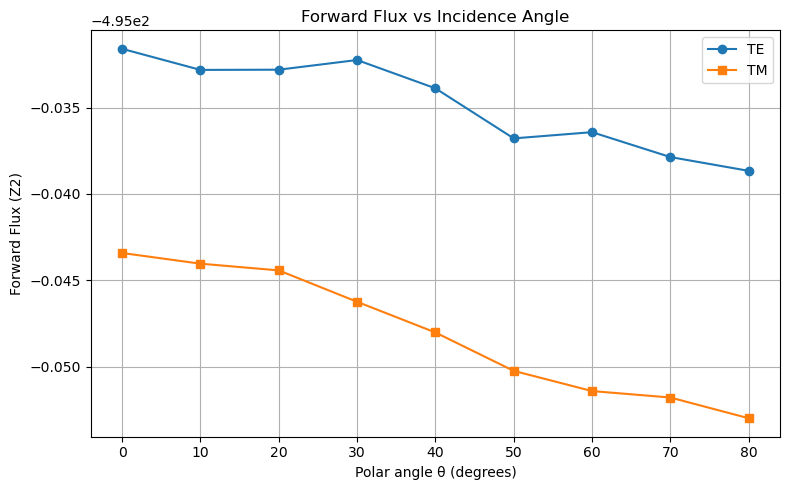

In [11]:
plt.figure(figsize=(8, 5))
plt.plot(df_flux["theta_deg"], df_flux["flux_TE"], "o-", label="TE")
plt.plot(df_flux["theta_deg"], df_flux["flux_TM"], "s-", label="TM")
plt.xlabel("Polar angle θ (degrees)")
plt.ylabel("Forward Flux (Z2)")
plt.title("Forward Flux vs Incidence Angle")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
